In [7]:
import os
import sys

def set_root_path():
    if os.getcwd().endswith('figures'):
        os.chdir('../')
set_root_path()
sys.path.append('python/')

In [8]:
import tqdm
import numpy as np
import mediapy as media
import time
import enum
from pathlib import Path

import mitsuba as mi
import drjit as dr

mi.set_variant("cuda_ad_rgb")

from core import losses
from core import mipmap_util
from core import image_util
from practical_reconstruction import figutils

In [3]:
def load_image():
  image_filename = 'figures/images/leopard.png'
  image_bitmap = mi.Bitmap(image_filename).convert(
      pixel_format=mi.Bitmap.PixelFormat.RGB,
      component_format=mi.Struct.Type.Float32,
      srgb_gamma=True,
  )
  return mi.TensorXf(image_bitmap)

def gaussian_noise(sample2, mean=0, std_dev=1):
  z0 = dr.sqrt(-2.0 * dr.log(sample2.x)) * dr.cos(2.0 * dr.pi * sample2.y)
  return z0 * std_dev + mean

def render_image(texture, sampler, render_resolution, noise_level, seed, spp):
  sampler.seed(
      seed=seed, wavefront_size=render_resolution[0] * render_resolution[1]
  )

  result = 0
  i = 0
  while dr.hint(i < spp):
    jitter = sampler.next_2d()
    xy = (
        mi.Point2f(
            dr.meshgrid(
                dr.arange(mi.UInt32, 0, render_resolution[0]),
                dr.arange(mi.UInt32, 0, render_resolution[1]),
            )
        )
        + jitter
    )
    si = dr.zeros(mi.SurfaceInteraction3f)
    si.uv = xy / mi.Vector2f(render_resolution)
    eval_result = texture.eval(si)
    for c in range(3):
      eval_result[c] += gaussian_noise(sampler.next_2d(),0,noise_level)
      eval_result[c] = dr.clip(eval_result[c],0,1)
    result += eval_result
    i += 1
  result /= spp
  return mi.TensorXf(
      dr.ravel(result), shape=(render_resolution[0], render_resolution[1], 3)
  )

def set_rendered_mip(
    opt, opt_key, rendered_params, resolution, nearest_neighbor
):
  image_data = opt[opt_key]
  if resolution == image_data.shape[:2]:
    rendered_params['data'] = image_data
    rendered_params.update()
    return
  num_downsamples = int(dr.log2(image_data.shape[0] / resolution[0]))
  for _ in range(num_downsamples):
    if nearest_neighbor:
      image_data = losses._downsample_image(image_data)
    else:
      image_data = losses._downsample_image(image_data)
  assert image_data.shape[:2] == tuple(resolution)
  rendered_params['data'] = image_data
  rendered_params.update()


def set_mip_from_laplacian(
    opt,
    opt_key_level_0,
    opt_key_level_1,
    rendered_params,
    resolution,
    nearest_neighbor,
):
  pyramid_level_1 = opt[opt_key_level_1]
  # We queried the lowest level, nothing to do !
  if resolution == pyramid_level_1.shape[:2]:
    rendered_params['data'] = pyramid_level_1
    rendered_params.update()
    return

  # Else we need to reconstruct the pyramid
  pyramid_level_0 = opt[opt_key_level_0]
  if nearest_neighbor:
    result = dr.upsample(pyramid_level_1, shape=resolution)
  else:
    result = image_util.bilinear_upsample(
      mi.Texture2f(pyramid_level_1), target_shape=resolution
    )
  reconstructed = pyramid_level_0 + result
  rendered_params['data'] = reconstructed
  rendered_params.update()

def filter_opt_gradients(opt, low_resolution, nearest_neighbor):
  grad_level_0 = dr.grad(opt.variables['level_0'])
  num_downsamples = int(dr.log2(grad_level_0.shape[0] / low_resolution[0]))
  grad_level_1 = mi.TensorXf(grad_level_0)
  for _ in range(num_downsamples):
    if nearest_neighbor:
      grad_level_1 = losses._downsample_image(grad_level_1)
    else:
      grad_level_1 = losses._downsample_image(grad_level_1)

  if nearest_neighbor:
    upsampled_grad_level_1 = dr.upsample(grad_level_1, shape=grad_level_0.shape)
  else:
    upsampled_grad_level_1 = image_util.bilinear_upsample(
        mi.Texture2f(grad_level_1), target_shape=grad_level_0.shape
    )
  dr.set_grad(opt.variables['level_0'], grad_level_0 + upsampled_grad_level_1 * 2**(2*num_downsamples))


,

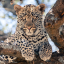
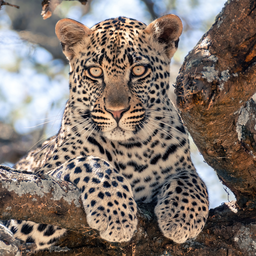

In [4]:
# Loading low/high-res reference images
render_resolution_high = [2048, 2048]
render_resolution_low = [64, 64]

image_ref = load_image()
image_ref_high_res = image_util.resize_to_width(
    image_ref, render_resolution_high[0]
)
image_ref_low_res = image_util.resize_to_width(
    image_ref, render_resolution_low[0]
)
media.show_images(
    [image_ref_low_res, image_ref_high_res], width=256
)

In [5]:
# Main optimization routine

class Config(enum.IntEnum):
  MIPMAP = 0
  FILTERED = 1
  PYRAMID = 2
  IDEAL_SCALES = 3


def run_optimization(
    config,
    lr,
    loss_fn,
    noise_level=0.0,
    spp=1,
    grad_spp=1,
    use_adam=True,
    nearest_neighbor=False,
    n_iterations=128,
    save_gradients=False,
    saved_iterations= np.arange(start=0,stop=128,step=16)
):
  sampler = mi.load_dict({'type': 'independent', 'sample_count': spp})
  default_value = 0.5

  ref_images = [image_ref_high_res, image_ref_low_res]

  # A placeholder used to get the downsampled or pyramid reconstruction image
  # for the rendering
  rendered_texture = mi.load_dict({
      'type': 'bitmap',
      'data': np.zeros_like(ref_images[0]),
      'filter_type': 'nearest' if nearest_neighbor else 'bilinear',
      'raw' :True,
  })
    
  if config in [Config.MIPMAP, Config.FILTERED]:
    # Only one optimizer variable (via downsampling or not before rendering)
    optimizer_variables = [
        mi.load_dict({
            'type': 'bitmap',
            'data': np.zeros_like(ref_images[0]) + default_value,
            'filter_type': 'nearest' if nearest_neighbor else 'bilinear',
            'raw' :True,
        })
    ]
    opt_keys = ['level_0']
  elif config == Config.IDEAL_SCALES:
    # Two levels of non-linked texture scales
    optimizer_variables = [
        mi.load_dict({
            'type': 'bitmap',
            'data': np.zeros_like(ref_image) + default_value,
            'filter_type': 'nearest' if nearest_neighbor else 'bilinear',
            'raw' :True,
        })
        for ref_image in ref_images
    ]
    opt_keys = ['level_0', 'level_1']
  else:
    assert config == Config.PYRAMID
    # And two levels of the pyramid in the optimizer
    optimizer_variables = [
        mi.load_dict({
            'type': 'bitmap',
            'data': np.zeros_like(ref_image) + value,
            'filter_type': 'nearest' if nearest_neighbor else 'bilinear',
            'raw' :True,
        })
        for ref_image, value in zip(ref_images, [0.0, default_value])
    ]
    opt_keys = ['level_0', 'level_1']

  rendered_texture_params = mi.traverse(rendered_texture)
  optimizer_variables_params = [
      mi.traverse(optimizer_variable)
      for optimizer_variable in optimizer_variables
  ]

  if use_adam:
    opt = mi.ad.Adam(lr=lr)
  else:
    opt = mi.ad.SGD(lr=lr, momentum=0.0)
  for optimizer_param, opt_key in zip(optimizer_variables_params, opt_keys):
    opt[opt_key] = optimizer_param['data']
    optimizer_param.update(opt)

  losses = []
  images = []
  grad_images = [[] for image_ref in ref_images]
  grad_images_m = [[] for image_ref in ref_images]
  grad_images_v = [[] for image_ref in ref_images]

  start_time = time.time()
  pbar = tqdm.trange(n_iterations)
  level_sampled = []
  np.random.seed(0)
  for i in pbar:

    mip_level = np.random.randint(2, size=1)[0]
    level_sampled.append(mip_level)
    mip_level = 0
    image_ref = ref_images[mip_level]
    render_resolution = image_ref.shape[:2]
    if config in [Config.MIPMAP, Config.FILTERED]:
      set_rendered_mip(
          opt,
          opt_keys[0],
          rendered_texture_params,
          render_resolution,
          nearest_neighbor,
      )
    elif config == Config.IDEAL_SCALES:
      set_rendered_mip(
          opt,
          opt_keys[mip_level],
          rendered_texture_params,
          render_resolution,
          nearest_neighbor,
      )
    elif config == Config.PYRAMID:
      set_mip_from_laplacian(
          opt,
          opt_keys[0],
          opt_keys[1],
          rendered_texture_params,
          render_resolution,
          nearest_neighbor,
      )

    with dr.suspend_grad():
      image_primal = render_image(
          rendered_texture,
          sampler,
          render_resolution,
          noise_level,
          seed=i,
          spp=spp,
      )
    image_grad = render_image(
        rendered_texture,
        sampler,
        render_resolution,
        noise_level,
        seed=i + n_iterations,
        spp=grad_spp,
    )

    image = dr.replace_grad(image_primal, image_grad)

    with dr.suspend_grad():
      if i in saved_iterations:
        images.append(image.numpy())

    loss = loss_fn(image, image_ref)
    dr.backward(loss)

    for index, opt_key in enumerate(opt_keys):
      if use_adam and save_gradients:
        m_tp, v_tp = opt.state[opt_key]
        grad_images_m[index].append(m_tp.numpy())
        grad_images_v[index].append(v_tp.numpy())
      if config == Config.FILTERED:
        filter_opt_gradients(opt, ref_images[1].shape, nearest_neighbor)
      if save_gradients:
        grad_images[index].append(dr.grad(opt.variables[opt_key]).numpy())

    opt.step()

    err_ref = loss.numpy()
    pbar.set_description(f'loss = {err_ref:6f}')
    losses.append(err_ref)

  end_time = time.time()
  print(f'Optimization took {(end_time - start_time):.3f} seconds')

  return (
      grad_images,
      grad_images_m,
      grad_images_v,
      images,
      losses,
      level_sampled,
      opt,
  )

In [6]:
# Running all experiments, /!\ this may take time /!\

spp = 32
grad_spp = 1
nearest_neighbor = True
noise_level = 0.4

# To also (re-)find the optimal parameters set this to True
recompute = False

if recompute:
  lrs_adams = [1e-4,1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
  lrs_sgd = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8,1e9,1e10]

  techniques = [Config.MIPMAP, Config.FILTERED, Config.PYRAMID]

  all_best_losses = []
  all_best_images = []
  all_best_lrs = []

  for use_adam in [False,True]:
    for technique in techniques:
      best_lr = 0
      best_loss = dr.inf
      best_losses = None
      best_images = None
      lrs = lrs_adams if use_adam else lrs_sgd
      for lr in lrs:
        (_, _, _, images, errors, _, _) = run_optimization(
            config=technique,
            lr=lr,
            loss_fn=losses.l1_norm,
            noise_level=noise_level,
            spp=spp,
            grad_spp=grad_spp,
            use_adam=use_adam,
            nearest_neighbor=nearest_neighbor,
        )
        if errors[-1] < best_loss:
          best_loss = errors[-1]
          best_lr = lr
          best_losses = list(errors)
          best_images = images
      print(
          f'For {technique.name} with {"adam" if use_adam else "sgd"} best lr:'
          f' {best_lr}/loss : {best_loss}'
      )
      all_best_losses.append(best_losses)
      all_best_images.append(best_images)
      all_best_lrs.append(best_lr)

  print(all_best_lrs)
  lr_sgd,lr_sgd_filtered,lr_sgd_pyramid,lr_adam,lr_adam_filtered,lr_adam_pyramid = all_best_lrs

  final_losses = [ best_losses[-1] for best_losses in all_best_losses]

  lr_sgd_filtered = lr_sgd_pyramid
else:
  lr_sgd,lr_sgd_filtered,lr_sgd_pyramid,lr_adam,lr_adam_filtered,lr_adam_pyramid = [100000.0, 1000.0, 1000.0, 0.01, 0.1, 0.01]

(
    sgd_grad_images,
    sgd_grad_images_m,
    sgd_grad_images_v,
    sgd_images,
    sgd_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.MIPMAP,
    lr=lr_sgd,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=False,
    nearest_neighbor=nearest_neighbor,
)

(
    sgd_filtered_grad_images,
    sgd_filtered_grad_images_m,
    sgd_filtered_grad_images_v,
    sgd_images_filtered,
    sgd_filtered_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.FILTERED,
    lr=lr_sgd_filtered,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=False,
    nearest_neighbor=nearest_neighbor,
)

(
    sgd_pyramid_grad_images,
    sgd_pyramid_grad_images_m,
    sgd_pyramid_grad_images_v,
    sgd_images_pyramid,
    sgd_pyramid_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.PYRAMID,
    lr=lr_sgd_pyramid,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=False,
    nearest_neighbor=nearest_neighbor,
)

(
    adam_grad_images,
    adam_grad_images_m,
    adam_grad_images_v,
    adam_images,
    adam_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.MIPMAP,
    lr=lr_adam,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=True,
    nearest_neighbor=nearest_neighbor,
)

(
    filtered_grad_images,
    filtered_grad_images_m,
    filtered_grad_images_v,
    adam_images_filtered,
    adam_filtered_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.FILTERED,
    lr=lr_adam_filtered,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=True,
    nearest_neighbor=nearest_neighbor,
)

(
    pyramid_grad_images,
    pyramid_grad_images_m,
    pyramid_grad_images_v,
    images_pyramid,
    adam_pyramid_losses,
    level_sampled,
    opt,
) = run_optimization(
    config=Config.PYRAMID,
    lr=lr_adam_pyramid,
    loss_fn = losses.l1_norm,
    noise_level=noise_level,
    spp=spp,
    grad_spp=grad_spp,
    use_adam=True,
    nearest_neighbor=nearest_neighbor,
)

if not recompute:
  all_best_images = [
      sgd_images,
      sgd_images_filtered,
      sgd_images_pyramid,
      adam_images,
      adam_images_filtered,
      images_pyramid,
  ]
  all_best_losses = [
    sgd_losses,
    sgd_filtered_losses,
    sgd_pyramid_losses,
    adam_losses,
    adam_filtered_losses,
    adam_pyramid_losses,
  ]
  final_losses = [ best_losses[-1] for best_losses in all_best_losses]  

RuntimeError: ​[xml_v.cpp:341] Unkown value type: <class 'numpy.ndarray'>

# Actual figure starts here after executing above

In [ ]:

import colorcet as cc
from matplotlib.gridspec import GridSpec as gs
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


all_losses = all_best_losses
labels = [
    'GD',
    'GD filtered',
    'GD pyramid',
    'Adam',
    'Adam filtered',
    'Adam pyramid',
]


class CustomHandlerLine2D(HandlerLine2D):

  def create_artists(
      self,
      legend,
      orig_handle,
      xdescent,
      ydescent,
      width,
      height,
      fontsize,
      trans,
  ):
    # Create a custom line with a modified linestyle
    line = super().create_artists(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    )
    for l in line:
      l.set_linestyle('solid')  # Change linestyle for legend
    return line


def plot_losses(ax):
  # cm_subsection = np.linspace(0, 0.925, len(all_losses))
  cm_subsection = np.linspace(0, 1.0, len(all_losses))
  plot_colors_a = [cc.cm['CET_L8'](x)[:3] for x in cm_subsection[:3]]
  cm_subsection = np.linspace(0, 0.9, len(all_losses))
  plot_colors_b = [cc.cm['CET_L8'](x)[:3] for x in cm_subsection[3:]]

  plot_colors_a = plt.cm.Accent([0,4,2])
  plot_colors_b = plt.cm.Accent([0,4,2])

  lines = []
  for i, (loss_values, label) in enumerate(zip(all_losses, labels)):
    if i in [0,1, 2]:
      line = ax.plot(
          loss_values,
          label=label,
          color=plot_colors_a[i] if i in [0, 1, 2] else plot_colors_b[i - 3],
          linestyle=(0 if i == 1 else 2, (2, 2)),
      )
    else:
      line = ax.plot(
          loss_values,
          label=label,
          color=plot_colors_a[i] if i in [0, 1, 2] else plot_colors_b[i - 3],
          linestyle='solid',
      )
    lines.append(line[0])
  ax.legend(
      edgecolor=(1, 1, 1, 0.0),
      facecolor=(1, 1, 1, 0.1),
      loc='upper center',
      ncols=2,
      columnspacing=0.5,
  )


FIGURE_DIR = "figures/pdfs"
FIGURE_NAME = 'understanding_pyramids'

half_res = False

main_crop_size = (1400, 1400)
main_crop_offset = (280, 30)
if half_res:
  main_crop_size = (int(main_crop_size[0] / 2), int(main_crop_size[1] / 2))
  main_crop_offset = (
      int(main_crop_offset[0] / 2),
      int(main_crop_offset[1] / 2),
  )

image_ref = image_ref_high_res
images = [im[-1] for im in all_best_images]
main_cropped_images = [
    figutils.crop_image(im, main_crop_offset, main_crop_size) for im in images
]
main_cropped_image_ref = figutils.crop_image(
    image_ref, main_crop_offset, main_crop_size
)

# Create the figure
fig = plt.figure(figsize=(figutils.TEXT_WIDTH,figutils.TEXT_WIDTH*0.347))
# Set up the grid using GridSpec
gs = fig.add_gridspec(
    4,
    8,
    figure=fig,
    height_ratios=[0.25, 0.25, 0.25, 0.25],
    width_ratios=[2, 1, 2, 1, 2, 1, 2, 1],
    wspace=0.01,
    hspace=0.225,
)  # Wider last column in both rows


ref_axis = fig.add_subplot(gs[0:2, 0])  # "Reference"
crop_ref_axes = [
    fig.add_subplot(gs[0, 1]),  # "Reference crop"
    fig.add_subplot(gs[1, 1]),  # "Reference crop"
]

plot_axis = fig.add_subplot(gs[2:, 0:2])  # "Plot"

image_axes = [
    fig.add_subplot(gs[0:2, 2]),  # "SGD"
    fig.add_subplot(gs[0:2, 4]),  # "SGD Filtered"
    fig.add_subplot(gs[0:2, 6]),  # "SGD Pyramid"
    fig.add_subplot(gs[2:4, 2]),  # "Adam"
    fig.add_subplot(gs[2:4, 4]),  # "Adam Filtered"
    fig.add_subplot(gs[2:4, 6]),  # "Adam Pyramid"
]

crop_1_image_axes = [
    fig.add_subplot(gs[0, 3]),  # "SGD crop"
    fig.add_subplot(gs[0, 5]),  # "SGD Filtered crop"
    fig.add_subplot(gs[0, 7]),  # "SGD Pyramid crop"
    fig.add_subplot(gs[2, 3]),  # "Adam crop"
    fig.add_subplot(gs[2, 5]),  # "Adam Filtered crop"
    fig.add_subplot(gs[2, 7]),  # "Adam Pyramid crop"
]
crop_2_image_axes = [
    fig.add_subplot(gs[1, 3]),  # "SGD crop"
    fig.add_subplot(gs[1, 5]),  # "SGD Filtered crop"
    fig.add_subplot(gs[1, 7]),  # "SGD Pyramid crop"
    fig.add_subplot(gs[3, 3]),  # "Adam crop"
    fig.add_subplot(gs[3, 5]),  # "Adam Filtered crop"
    fig.add_subplot(gs[3, 7]),  # "Adam Pyramid crop"
]

image_titles = [
    'Gradient descent (GD)',
    'GD filtered',
    'GD pyramid',
    'Adam',
    'Adam filtered',
    'Adam pyramid',
]
bottom_titles = [
    '',
    'Adam',
    '',
    'Adam filtered',
    '',
    'Adam pyramid',
    '',
]

crop_size_1 = (250, 250)
crop_size_2 = (250, 250)
crop_size_1 = (200, 200)
crop_size_2 = (200, 200)
crop_1_offset = (951, 818)
crop_2_offset = (1006, 434)
line_width = 0.75
crop_1_color = 'orange'
crop_2_color = 'green'
title_pad = 1

if half_res:
  crop_size_1 = (int(crop_size_1[0] / 2), int(crop_size_1[1] / 2))
  crop_size_2 = (int(crop_size_2[0] / 2), int(crop_size_2[1] / 2))
  crop_1_offset = (int(crop_1_offset[0] / 2), int(crop_1_offset[1] / 2))
  crop_2_offset = (int(crop_2_offset[0] / 2), int(crop_2_offset[1] / 2))


# Brightness boost
boost = np.sqrt(1.5)
boost = 1.0

label_pad = 1.6

# Reference
if True:
  ref_axis.imshow(boost * main_cropped_image_ref, aspect='equal')
  ref_axis.set_title('Reference', pad=title_pad)
  ref_axis.set_xticks([])
  ref_axis.set_yticks([])
  rect_closeup = Rectangle(
      np.array(crop_1_offset) - np.array(main_crop_offset),
      crop_size_1[0],
      crop_size_1[1],
      linewidth=line_width,
      edgecolor=crop_1_color,
      facecolor='none',
  )
  ref_axis.add_patch(rect_closeup)
  rect_closeup = Rectangle(
      np.array(crop_2_offset) - np.array(main_crop_offset),
      crop_size_2[0],
      crop_size_2[1],
      linewidth=line_width,
      edgecolor=crop_2_color,
      facecolor='none',
  )
  ref_axis.add_patch(rect_closeup)
  crop_ref_axes[0].imshow(
      boost * figutils.crop_image(image_ref, crop_1_offset, crop_size_1),
      aspect='equal',
  )
  crop_ref_axes[0].spines[:].set_color(crop_1_color)
  crop_ref_axes[0].spines[:].set_linewidth(line_width)
  crop_ref_axes[0].set_xlabel(r'$L_1$' + ' error', labelpad=label_pad)

  crop_ref_axes[1].imshow(
      boost * figutils.crop_image(image_ref, crop_2_offset, crop_size_2),
      aspect='equal',
  )
  crop_ref_axes[1].spines[:].set_color(crop_2_color)
  crop_ref_axes[1].spines[:].set_linewidth(line_width)
  for i in range(2):
    crop_ref_axes[i].set_xticks([])
    crop_ref_axes[i].set_yticks([])

# Method images
for i, (ax, title) in enumerate(zip(image_axes, image_titles)):
  ax.set_title(title, pad=title_pad)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(boost * main_cropped_images[i], aspect='equal')

# Crop 1 images
for i, ax in enumerate(crop_1_image_axes):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(
      boost * figutils.crop_image(images[i], crop_1_offset, crop_size_1),
      aspect='equal',
  )
  ax.spines[:].set_color(crop_1_color)
  ax.spines[:].set_linewidth(line_width)
  if i == 5:
    label = r'\textbf{' + f'{final_losses[i]:.4f}' + r'}'
  else:
    label = f'{final_losses[i]:.4f}'
  ax.set_xlabel(label, labelpad=label_pad)

# Crop 1 images
for i, ax in enumerate(crop_2_image_axes):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(
      boost * figutils.crop_image(images[i], crop_2_offset, crop_size_2),
      aspect='equal',
  )
  ax.spines[:].set_color(crop_2_color)
  ax.spines[:].set_linewidth(line_width)

# Plot
plot_losses(plot_axis)
plot_axis.set_xlabel('Iteration', labelpad=0)
plot_axis.set_ylabel(r'$L_1$' + ' loss', labelpad=1)
plot_axis.set_title("Objective function values", pad=title_pad)
plot_axis.grid(which='minor', alpha=0.05)
plot_axis.grid(which='major', alpha=0.5)
plot_axis.minorticks_on()

figutils.force_post_crop_size(fig, figutils.TEXT_WIDTH)

In [ ]:
figutils.savefig(
    fig,
    name=Path(FIGURE_NAME),
    fig_directory=Path(FIGURE_DIR),
    dpi=300,
    pad_inches=0.005,
    bbox_inches="tight",
    compress=False,
    target_width=figutils.TEXT_WIDTH,
    backend=None,
)